## Rennes Data Challenge 2023 

Mathis Derenne

---

### Neural networks

Work in progress. Results were not satisfying. I am starting over.

In [79]:
import datetime
from utils import load_data, validation_split

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import IPython
from IPython import display
sns.set_theme()
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [80]:
X, y = load_data()

dateindex = X.index
n = len(X[X.index < validation_split])

X_train = X.iloc[:int(n*0.75)].copy()
y_train = y.iloc[:int(n*0.75)].copy()

X_test = X.iloc[int(n*0.75):].copy()
y_test = y.iloc[int(n*0.75):].copy()

X_val = X_test[X_test.index >= validation_split].copy()
y_val = y_test[y_test.index >= validation_split].copy()

reset_index = lambda df: df.reset_index(drop=True)

# X_train = reset_index(X_train)
# X_val = reset_index(X_val)
# X_test = reset_index(X_test)

# y_train = reset_index(y_train)
# y_val = reset_index(y_val)
# y_test = reset_index(y_test)

### Preprocessing Pipeline

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=0.7, svd_solver='full'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
X_val = preprocessor.transform(X_val)

In [82]:
n_pca_components = X_train.shape[1]
pca_columns = [f'PC{i+1}' for i in range(n_pca_components)]

X_train = pd.DataFrame(X_train, columns=pca_columns)
X_test = pd.DataFrame(X_test, columns=pca_columns)
X_val = pd.DataFrame(X_val, columns=pca_columns)

# Add target to the dataframe
target = 'Close_BTC'

X_train[target] = y_train
X_test[target] = y_test
X_val[target] = y_val

X_train.shape, X_test.shape, X_val.shape

((984, 2), (477, 2), (148, 2))

In [83]:
# # Use KNN to impute missing values
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=5)
# train_df_preprocess = imputer.fit_transform(train_df_no_target)
# val_df_preprocess = imputer.transform(val_df_no_target)
# test_df_preprocess = imputer.transform(test_df_no_target)
# # Scale data
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# train_df_preprocess = scaler.fit_transform(train_df_preprocess)
# val_df_preprocess = scaler.transform(val_df_preprocess)
# test_df_preprocess = scaler.transform(test_df_preprocess)
# # Scale targets
# scaler_target = StandardScaler()
# train_df_target = pd.DataFrame(scaler_target.fit_transform(train_df_target), columns=target_features)
# val_df_target = pd.DataFrame(scaler_target.transform(val_df_target), columns=target_features)
# test_df_target = pd.DataFrame(scaler_target.transform(test_df_target), columns=target_features)
# # Apply PCA
# from sklearn.decomposition import PCA
# pca = PCA(n_components=0.85)
# pca.fit(train_df_preprocess)
# train_df_preprocess = pca.transform(train_df_preprocess)
# val_df_preprocess = pca.transform(val_df_preprocess)
# test_df_preprocess = pca.transform(test_df_preprocess)
# # Re-add targets
# train_df_preprocess = pd.DataFrame(train_df_preprocess)
# train_df_preprocess = pd.concat([train_df_preprocess, train_df_target[['Close_BTC', 'Close_ETH']]], axis=1)
# val_df_preprocess = pd.DataFrame(val_df_preprocess)
# # Make val_df_preprocess use index from val_df_target
# val_df_preprocess.index = val_df_target.index
# val_df_preprocess = pd.concat([val_df_preprocess, val_df_target[['Close_BTC', 'Close_ETH']]], axis=1)
# test_df_preprocess = pd.DataFrame(test_df_preprocess)
# test_df_preprocess.index = test_df_target.index
# test_df_preprocess = pd.concat([test_df_preprocess, test_df_target[['Close_BTC', 'Close_ETH']]], axis=1)

# Print shape
# num_features = X_train.shape[1]
# column_indices = {name: i for i, name in enumerate(X_train.columns)}

# train_df = X_train
# test_df = X_test
# val_df = X_val

# train_df.shape, test_df.shape, val_df.shape

### Class definition

In [84]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df = X_train, val_df = X_val, test_df = X_test,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [85]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [86]:
def plot(self, model=None, plot_col=target, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

In [87]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset


In [88]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

### Defining windows

In [89]:
WIDTH = 2

full_window = WindowGenerator(input_width=len(X_train)-1, label_width=len(X_train)-1, shift=1, label_columns=[target])
wide_window = WindowGenerator(input_width=WIDTH, label_width=WIDTH, shift=1, label_columns=[target])
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=[target])

### Defining model fitting and training

In [90]:
MAX_EPOCHS = 100
LEARNING_RATE = 1e-4*2
PATIENCE = 5

def compile_and_fit(model, window, patience=PATIENCE):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)
  
  model.compile(loss=tf.losses.MeanSquaredError(),
                # optimizer=tf.keras.optimizers.Adam(),
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE),
                metrics=[tf.metrics.MeanAbsoluteError()])

  print("Training data shape:", window.train)
  print("Validation data shape:", window.val)

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping],
                      verbose=1)
  return history

### Linear model

In [91]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 2)
Output shape: (32, 1, 1)


In [92]:
history = compile_and_fit(linear, wide_window)

IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=0)

5/5 [==============================] - 0s 5ms/step - loss: nan - mean_absolute_error: nan


In [93]:
# wide_window.plot(linear)
# full_window.plot(linear)

### Dense neural net model

In [94]:
from tensorflow.keras import regularizers

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, wide_window)

val_performance['Dense'] = dense.evaluate(wide_window.val)
performance['Dense'] = dense.evaluate(wide_window.test, verbose=0)

Training data shape: <_MapDataset element_spec=(TensorSpec(shape=(None, 2, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2, 1), dtype=tf.float32, name=None))>
Validation data shape: <_MapDataset element_spec=(TensorSpec(shape=(None, 2, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2, 1), dtype=tf.float32, name=None))>
Epoch 1/100
31/31 [==============================] - 1s 30ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/100
31/31 [==============================] - 1s 21ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/100
31/31 [==============================] - 1s 21ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/100
31/31 [==============================] - 1s 21ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 5/100
5/5 [==============================]

### Multi-step dense model

In [95]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [96]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', multi_step_dense(wide_window.example[0]).shape)

Input shape: (32, 2, 2)
Output shape: (32, 1, 1)


In [97]:
history = compile_and_fit(multi_step_dense, wide_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(wide_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(wide_window.test, verbose=0)

### LSTM model

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 2, 2)
Output shape: (32, 2, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window)

# IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Training data shape: <_MapDataset element_spec=(TensorSpec(shape=(None, 2, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2, 1), dtype=tf.float32, name=None))>
Validation data shape: <_MapDataset element_spec=(TensorSpec(shape=(None, 2, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2, 1), dtype=tf.float32, name=None))>
Epoch 1/100
31/31 [==============================] - 2s 25ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/100
31/31 [==============================] - 1s 16ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 5/100
5/5 [==============================]

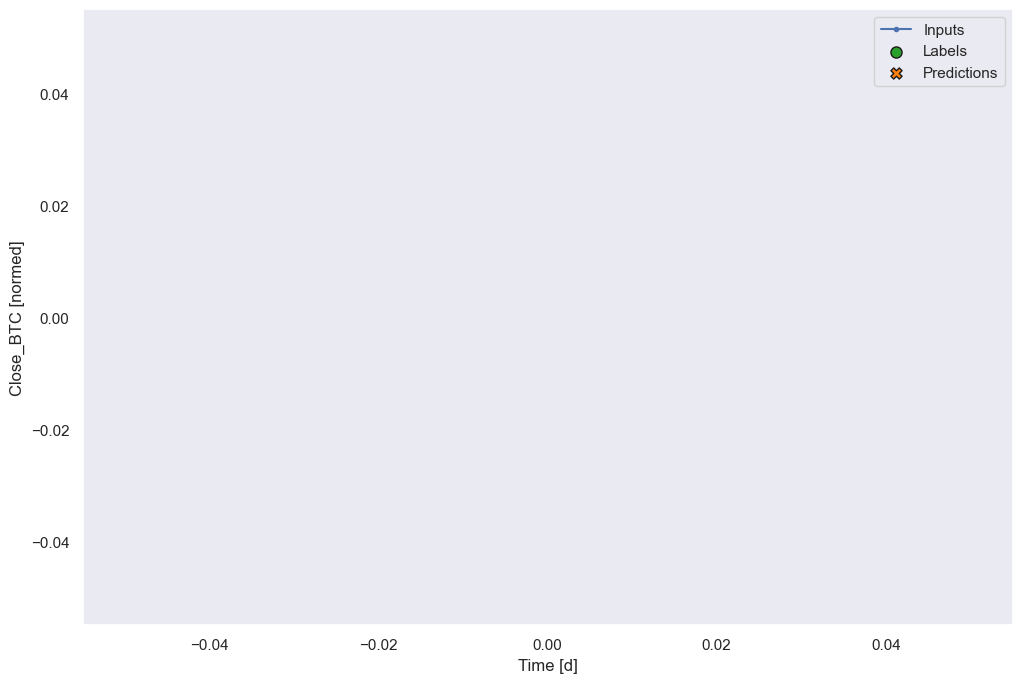

In [ ]:
full_window.plot(lstm_model)

### SDAE LSTM model

In [ ]:
# Define the SDAE model
sdae_lstm = tf.keras.models.Sequential([
    # SDAE
    # Encoder
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    # Decoder
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    # LSTM
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

# Compile and fit the model
history = compile_and_fit(sdae_lstm, wide_window)

# Evaluate the model
val_performance['SDAE_LSTM'] = sdae_lstm.evaluate(wide_window.val)
performance['SDAE_LSTM'] = sdae_lstm.evaluate(wide_window.test, verbose=0)

Training data shape: <_MapDataset element_spec=(TensorSpec(shape=(None, 2, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2, 1), dtype=tf.float32, name=None))>
Validation data shape: <_MapDataset element_spec=(TensorSpec(shape=(None, 2, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2, 1), dtype=tf.float32, name=None))>
Epoch 1/100
31/31 [==============================] - 3s 46ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/100
31/31 [==============================] - 1s 22ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/100
31/31 [==============================] - 1s 22ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/100
31/31 [==============================] - 1s 23ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 5/100
5/5 [==============================]

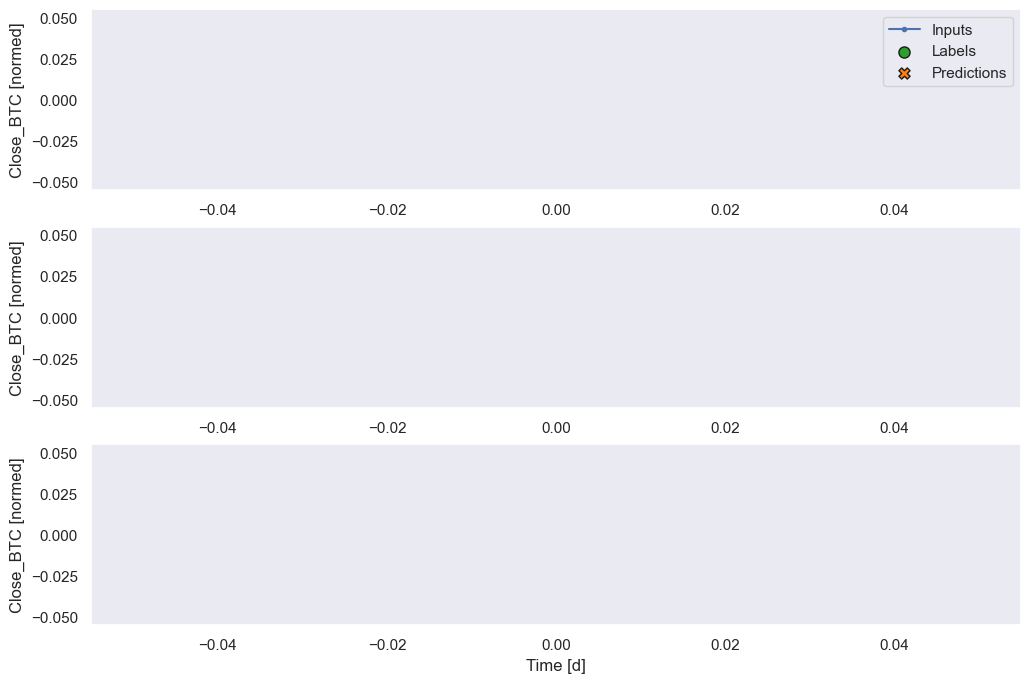

In [ ]:
wide_window.plot(sdae_lstm)

### Results

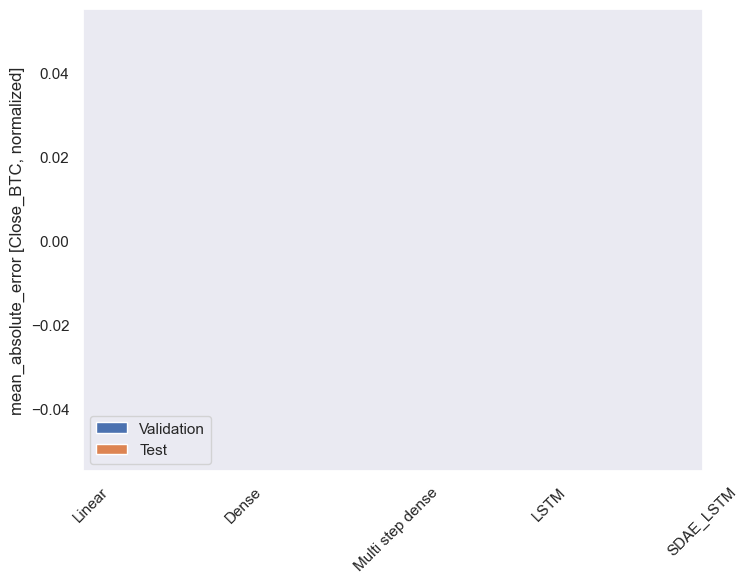

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Close_BTC, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [ ]:
# Columns : Test MSE, Validation MSE, Test MAE, Validation MAE
result = pd.DataFrame(columns=['Test MSE', 'Validation MSE', 'Test MAE', 'Validation MAE'])
for model in performance.keys():
  result.loc[model] = [performance[model][0], val_performance[model][0], performance[model][1], val_performance[model][1]]



display((f"window width: {WIDTH}", f"patience : {PATIENCE}",f"learning rate : {LEARNING_RATE}", f"max epoch : {MAX_EPOCHS}"))
result

TypeError: 'module' object is not callable